### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-29c1ccd3-8650-d23f-540a-53c5950f5fc0)


In [2]:
%%capture
!pip install diffusers
!pip install daam
!pip install git+https://github.com/RishiDarkDevil/daam-i2i.git
!pip install git+https://github.com/RishiDarkDevil/TITAN.git

### Import Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [3]:
# Plotting
from matplotlib import pyplot as plt

# Data Handling
import numpy as np

# Image Processing
from PIL import Image

# Image Generation
from diffusers import StableDiffusionPipeline

# Heatmap generation
import daam
import daami2i

# annotations
import titan

### Load Model

In [8]:
DEVICE = 'cuda' # device

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [9]:
model = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

### DAAM Image Attention

In [4]:
prompt = ['Dinner table with chairs and food with people']

In [5]:
processed_prompt = titan.PromptHandler().clean_prompt(prompt)

Loading Models...

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


Done
Tokenizing...Done
POS Tagging and Lemmatizing...Done
Processing...Done


In [6]:
processed_prompt

[('dinner table with chairs and food with people',
  ['dinner', 'table', 'chairs', 'food', 'people'],
  ['dinner', 'table', 'chair', 'food', 'people'])]

In [10]:
with daam.trace(model) as daam_trc:
  with daami2i.trace(model) as daami2i_trc:
    output_image = model(processed_prompt[0][0]).images
    image_global_heat_map = daami2i_trc.compute_global_heat_map()
    word_global_heat_map = daam_trc.compute_global_heat_map()

  0%|          | 0/51 [00:00<?, ?it/s]

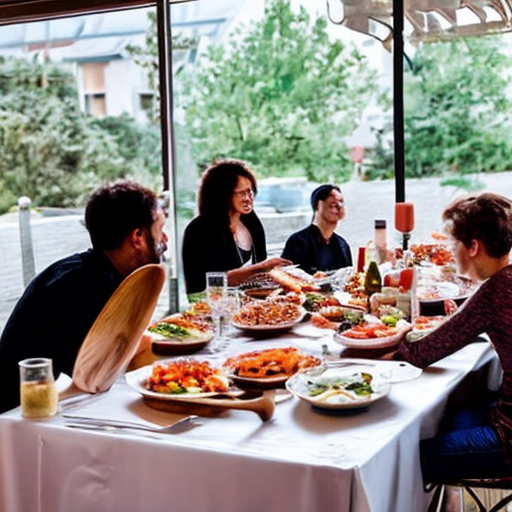

In [11]:
output_image[0]

In [12]:
annotations = list()
object_annotator = titan.ObjectAnnotator()

In [14]:
for i, word in enumerate(processed_prompt[0][1]):
  # Compute heatmap for a non-stopword
  word_heatmap = word_global_heat_map.compute_word_heat_map(word).expand_as(output_image[0]).numpy()

  # Annotate the Word Heatmap for current word
  anns = object_annotator.wordheatmap_to_annotations(
    word_heatmap, 100*i, 1, i
    )
  
  annotations.append(anns)

In [16]:
len(annotations)

5

In [48]:
len(annotations[0])

2

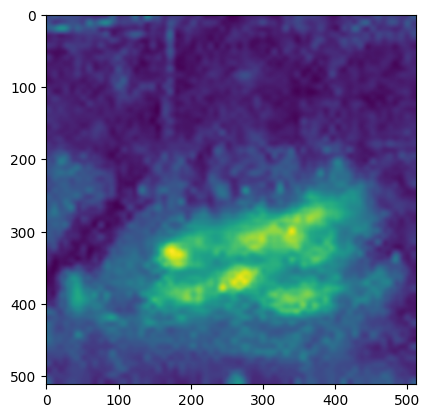

In [49]:
plt.imshow(word_global_heat_map.compute_word_heat_map(processed_prompt[0][1][0]).expand_as(output_image[0]).numpy())

In [50]:
heatmaps = list()
for k in range(len(annotations[0])):
  # Compute heatmap for inner pixels for contour boundary specified
  pixel_heatmap = image_global_heat_map.compute_contour_heat_map(
      [[annotations[0][k]['segmentation'][0][i], annotations[0][k]['segmentation'][0][i+1]] for i in range(0, len(annotations[0][k]['segmentation'][0]), 2)], 
      512, 512).expand_as(output_image[0]).numpy()

  # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
  heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)

  heatmaps.append(heatmap[np.newaxis, :, :])

In [51]:
heatmap = np.mean(np.concatenate(heatmaps), 0)

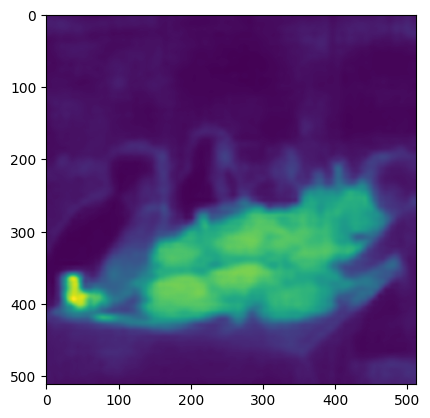

In [52]:
plt.imshow(heatmap)

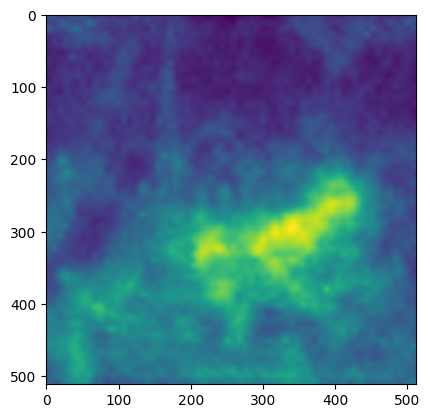

In [28]:
plt.imshow(word_global_heat_map.compute_word_heat_map(processed_prompt[0][1][1]).expand_as(output_image[0]).numpy())

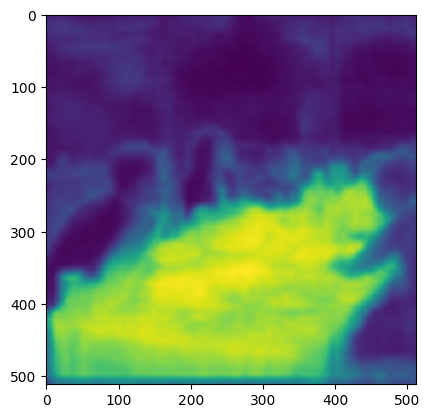

In [25]:
# Compute heatmap for inner pixels for contour boundary specified
pixel_heatmap = image_global_heat_map.compute_contour_heat_map(
    [[annotations[1][0]['segmentation'][0][i], annotations[1][0]['segmentation'][0][i+1]] for i in range(0, len(annotations[1][0]['segmentation'][0]), 2)], 
    512, 512).expand_as(output_image[0]).numpy()

# Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)

plt.imshow(heatmap)

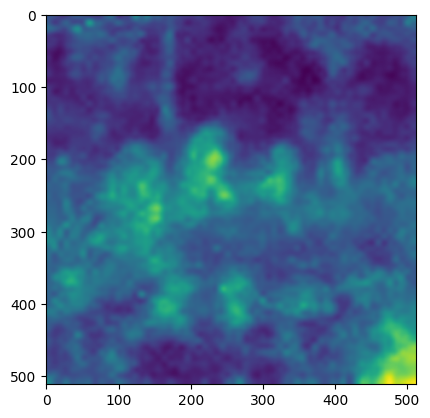

In [29]:
plt.imshow(word_global_heat_map.compute_word_heat_map(processed_prompt[0][1][2]).expand_as(output_image[0]).numpy())

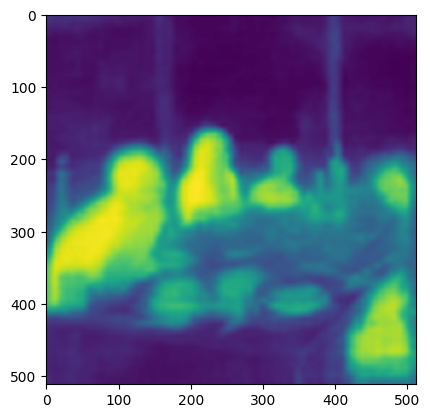

In [31]:
# Compute heatmap for inner pixels for contour boundary specified
pixel_heatmap = image_global_heat_map.compute_contour_heat_map(
    [[annotations[2][0]['segmentation'][0][i], annotations[2][0]['segmentation'][0][i+1]] for i in range(0, len(annotations[2][0]['segmentation'][0]), 2)], 
    512, 512).expand_as(output_image[0]).numpy()

# Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)

plt.imshow(heatmap)

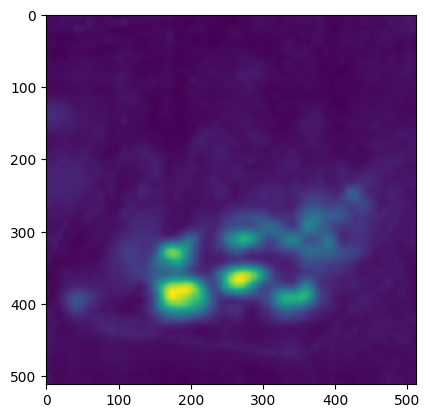

In [33]:
plt.imshow(word_global_heat_map.compute_word_heat_map(processed_prompt[0][1][3]).expand_as(output_image[0]).numpy())

In [36]:
heatmaps = list()
for k in range(len(annotations[3])):
  # Compute heatmap for inner pixels for contour boundary specified
  pixel_heatmap = image_global_heat_map.compute_contour_heat_map(
      [[annotations[3][k]['segmentation'][0][i], annotations[3][k]['segmentation'][0][i+1]] for i in range(0, len(annotations[3][k]['segmentation'][0]), 2)], 
      512, 512).expand_as(output_image[0]).numpy()

  # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
  heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)

  heatmaps.append(heatmap[np.newaxis, :, :])

In [41]:
heatmap = np.mean(np.concatenate(heatmaps), 0)

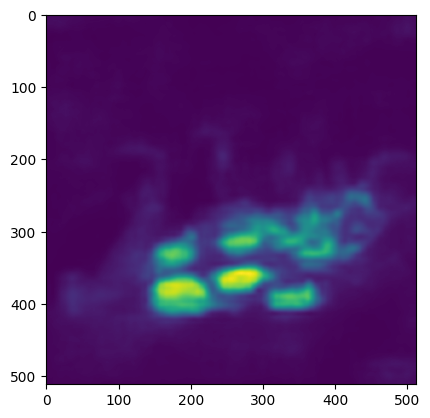

In [42]:
plt.imshow(heatmap)

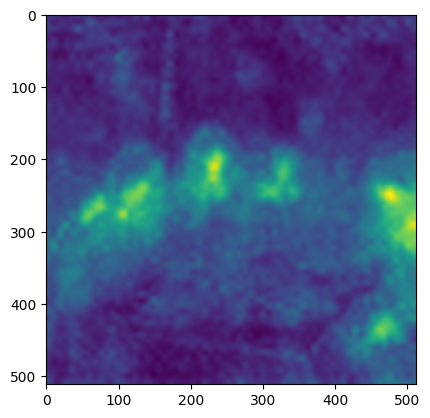

In [44]:
plt.imshow(word_global_heat_map.compute_word_heat_map(processed_prompt[0][1][4]).expand_as(output_image[0]).numpy())

In [45]:
heatmaps = list()
for k in range(len(annotations[4])):
  # Compute heatmap for inner pixels for contour boundary specified
  pixel_heatmap = image_global_heat_map.compute_contour_heat_map(
      [[annotations[4][k]['segmentation'][0][i], annotations[4][k]['segmentation'][0][i+1]] for i in range(0, len(annotations[4][k]['segmentation'][0]), 2)], 
      512, 512).expand_as(output_image[0]).numpy()

  # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
  heatmap = np.array(pixel_heatmap * 255, dtype = np.uint8)

  heatmaps.append(heatmap[np.newaxis, :, :])

In [46]:
heatmap = np.mean(np.concatenate(heatmaps), 0)

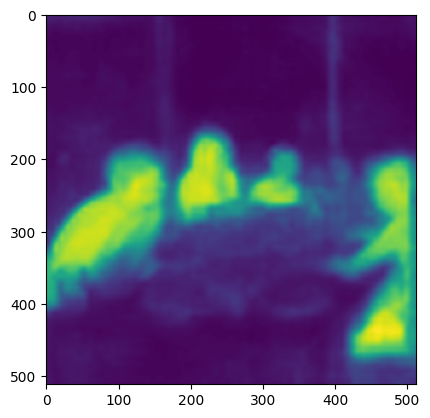

In [47]:
plt.imshow(heatmap)